# Galaxy morphology classification with Convolutional Neural Networks

A course project by Paul Hildebrandt for [PH0101](https://www.ph.tum.de/academics/org/cc/mh/PH0101/)


[Report](https://physics.sh/galaxyclass)

[Repository](https://github.com/paulphys/galaxyclass)

## Setting up the environment

In [ ]:
# Install dependencies
# ---------------------------

!pip install tensorflow
!pip install numpy
!pip install matplotlib
!pip install scipy
!pip install sklearn
!pip install opencv-python
!pip install pandas
!pip install seaborn

In [1]:
# Import dependencies
# ---------------------------

import time, os, sys, pickle, random, cv2, scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import Javascript, display, Markdown, clear_output
from tensorflow.keras import backend as K
from tensorflow.keras import layers, metrics, losses, callbacks, regularizers
from tensorflow.python.client import device_lib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

print("Python version: {}".format(sys.version_info))
print("Numpy version: {}".format(np.version.version))
print("Tensorflow version: {}".format(tf.__version__))

# Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',titleweight='bold', titlesize=16, titlepad=20)
plt.rc('image', cmap='magma')

Python version: sys.version_info(major=3, minor=8, micro=10, releaselevel='final', serial=0)
Numpy version: 1.22.1
Tensorflow version: 2.7.0


In [ ]:
# Initialize GPU (full-access)
# ---------------------------

strategy = tf.distribute.get_strategy()
print(tf.config.experimental.list_logical_devices('GPU'))

In [ ]:
# Use this snippet to restrict TensorFlow to only allocate 5GB of video memory
# (must be run instead of the full-access initialization)
# ---------------------------

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=5000)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)
strategy = tf.distribute.get_strategy()

In [ ]:
# Download dataset
# ---------------------------

!curl -LO https://physics.sh/galaxyclass-data.zip
!unzip -q -n galaxyclass-data.zip -d data
!rm galaxyclass-data.zip

In [2]:
# Data loader
# ---------------------------

directory = 'data/'
model_dir = directory + "models/"
training_dir = directory + "images_training/"
test_dir = directory + "images_test/"

labels = pd.read_csv(directory + 'training_solutions.csv')
images = [f for f in os.listdir(training_dir) if os.path.isfile(os.path.join(training_dir, f))]
labels.GalaxyID = labels.GalaxyID.apply(lambda id: str(int(id)) + '.jpg')

label_desc = ['Smooth','Featured or disc','Star or artifact','Edge on','Not edge on','Bar through center',
        'No bar','Spiral','No Spiral','No bulge','Just noticeable bulge','Obvious bulge','Dominant bulge',
        'Odd Feature','No Odd Feature','Completely round','In between','Cigar shaped','Ring (Oddity)',
        'Lens or arc (Oddity)','Disturbed (Oddity)','Irregular (Oddity)','Other (Oddity)','Merger (Oddity)',
        'Dust lane (Oddity)','Rounded bulge','Boxy bulge','No bulge','Tightly wound arms','Medium wound arms',
        'Loose wound arms','1 Spiral Arm','2 Spiral Arms','3 Spiral Arms','4 Spiral Arms','More than four Spiral Arms',"Can't tell"]

groups = [
          ['Class1.1', 'Class1.2', 'Class1.3'],
          ['Class2.1', 'Class2.2'],
          ['Class3.1', 'Class3.2'],
          ['Class4.1', 'Class4.2'],
          ['Class5.1', 'Class5.2', 'Class5.3', 'Class5.4'],
          ['Class6.1', 'Class6.2'],
          ['Class7.1', 'Class7.2', 'Class7.3'],
          ['Class8.1', 'Class8.2', 'Class8.3', 'Class8.4', 'Class8.5', 'Class8.6', 'Class8.7'],
          ['Class9.1','Class9.2','Class9.3'],
          ['Class10.1', 'Class10.2', 'Class10.3'],
          ['Class11.1','Class11.2','Class11.3','Class11.4','Class11.5','Class11.6']
]

!mkdir -p data/processed/150x150
DIR_150 = directory + "processed/150x150/"

In [4]:
# Utility functions / misc
# ---------------------------

# Element-wise RMSE score
def RMSE(pred, truth):
    return np.sqrt(np.mean(np.square(np.array(pred).flatten() - np.array(truth).flatten())))

# Pickle wrapper
def save(obj, file):
    pickle.dump(obj, open(directory + file ,'wb'))
    
# Returns average color of image
def average_color(pic):
    return np.sum(pic, axis=(1,2)) / (pic.shape[1] * pic.shape[2])

# Returns center pixels
def center_pixel(pic):
    return pic[:,int(pic.shape[1] / 2),int(pic.shape[2] / 2),:]

# Generate batches of numpy arrays from a list of image filenames.
def image_generator(pics, path=training_dir, batch_size=30, rotate=False, size=100, save=False,
                    retrieve=False):
    l = len(pics)
    batches = int(l/batch_size)
    leftover = l % batch_size
    for batch in range(batches):
        start = batch * batch_size
        this_batch = pics[start:start+batch_size]
        if rotate:
            yield np.array([ 
                            scipy.misc.imresize(
                                scipy.ndimage.rotate(
                                plt.imread(path + pic, format='jpg'),
                                reshape=False,
                                angle=random.randint(0,360, random_seed=RANDOM)
                                ),
                                size=size
                            )
                            
                            for pic in this_batch])
        else:
            yield np.array([ plt.imread(path + pic, format='jpg') for pic in this_batch])
    start = batches * batch_size
    this_batch = pics[start:start+leftover]
    yield np.array([ plt.imread(path + pic, format='jpg') for pic in this_batch])

## Exploratory Data Analysis

The objective of my exploratory data analysis was to get a better understanding of the dataset, I wanted to learn about how the classes are distributed, as well as how the galaxies are displayed in the images, to then better inform my preprocessing and deep learning strategies. For a start, this is what the highest confidence example for each feature looks like. Keep in mind that the classes are still representing a decision tree.

### The highest confidence example for each feature

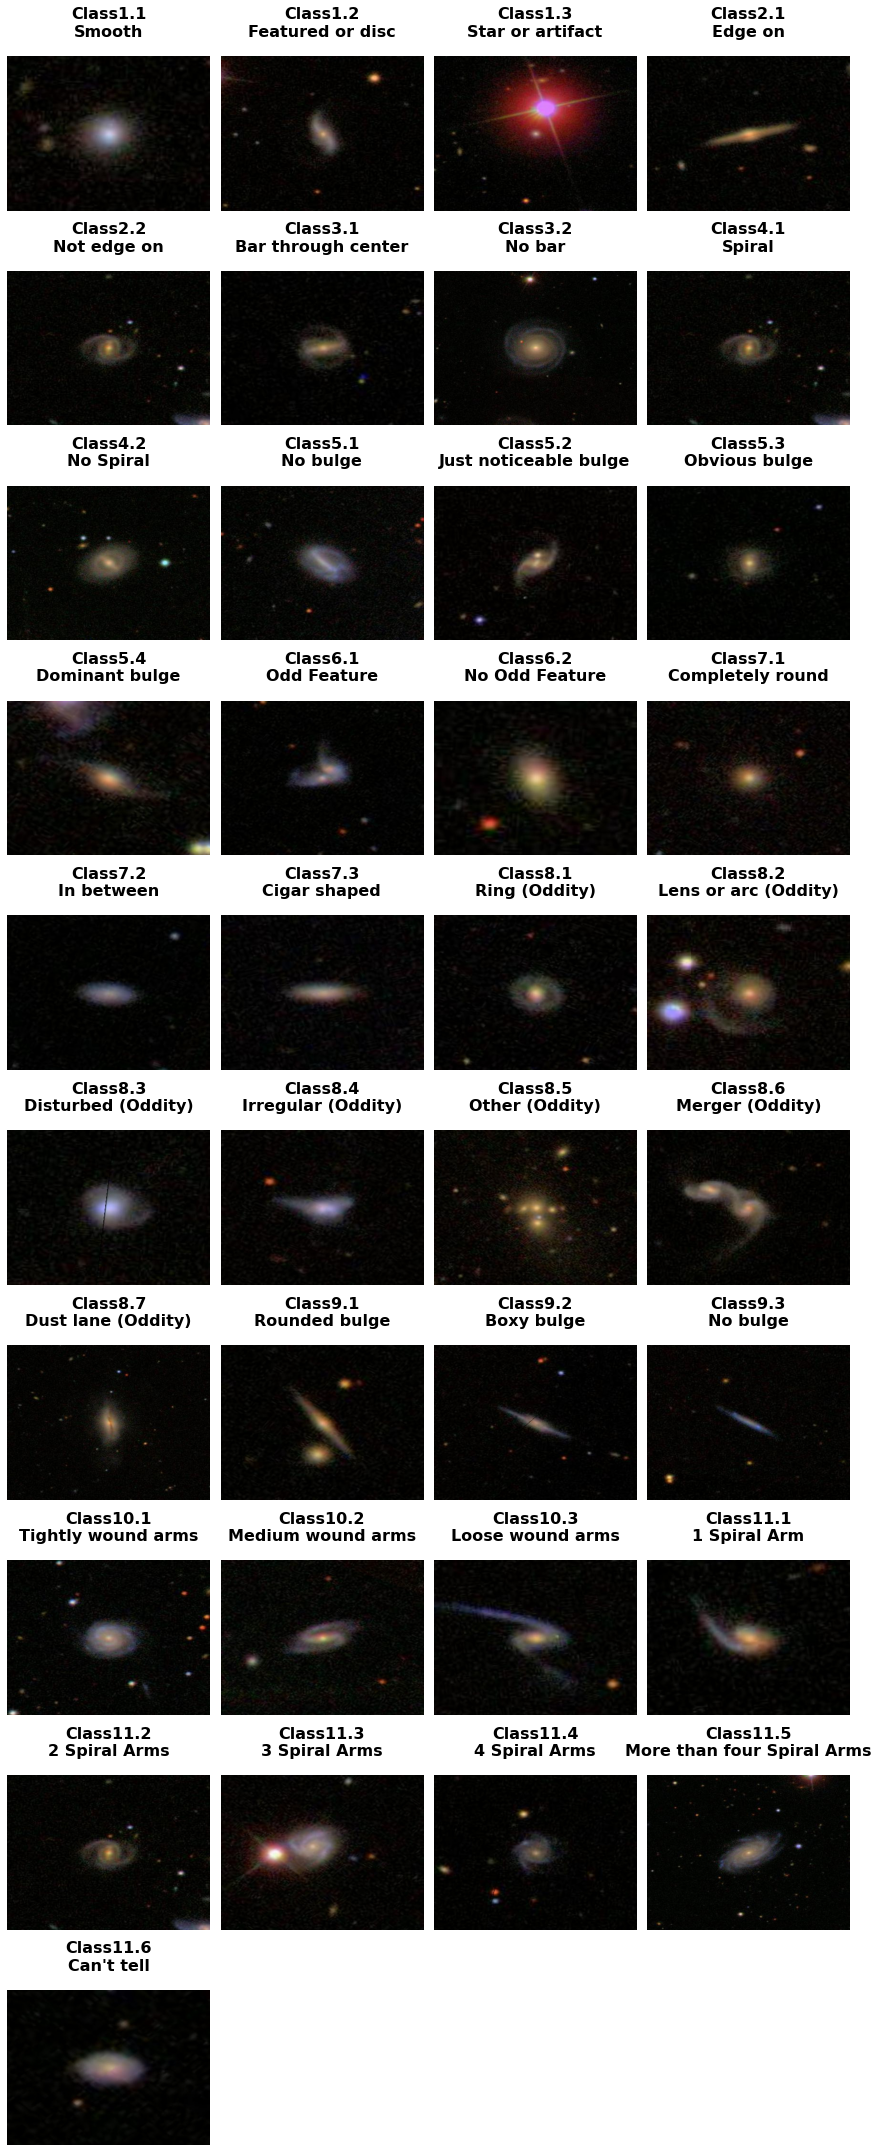

In [5]:
display(Markdown("### The highest confidence example for each feature"))
size = 12
fig = plt.figure('', figsize=[size,size*10/4])
plt.axis('off')
plt.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')
for i, feature in enumerate(labels.columns[1:]):
    fig.add_subplot(10, 4, i+1)
    plt.title(feature + "\n" + label_desc[i]) 
    plt.axis('off')
    plt.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')
    file = labels.iloc[labels[feature].idxmax()].GalaxyID
    img = plt.imread(training_dir + file, format='jpg')
    plt.imshow(img, aspect='auto', cmap='gray')
fig.tight_layout(pad=1.0)
plt.show()

In [3]:
display(labels)

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008.jpg,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.000000,0.000000,0.0,0.325512
1,100023.jpg,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.000000,0.000000,0.0,0.000000
2,100053.jpg,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,100078.jpg,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.000000,0.000000,0.0,0.000000
4,100090.jpg,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61573,999948.jpg,0.510379,0.489621,0.000000,0.059207,0.430414,0.000000,0.430414,0.226257,0.204157,...,0.000000,0.226257,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.226257
61574,999950.jpg,0.901216,0.098784,0.000000,0.000000,0.098784,0.000000,0.098784,0.000000,0.098784,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
61575,999958.jpg,0.202841,0.777376,0.019783,0.116962,0.660414,0.067245,0.593168,0.140022,0.520391,...,0.000000,0.000000,0.090673,0.049349,0.000000,0.067726,0.000000,0.000000,0.0,0.072296
61576,999964.jpg,0.091000,0.909000,0.000000,0.045450,0.863550,0.022452,0.841098,0.795330,0.068220,...,0.000000,0.068398,0.318132,0.408799,0.227464,0.408799,0.090668,0.023065,0.0,0.045334


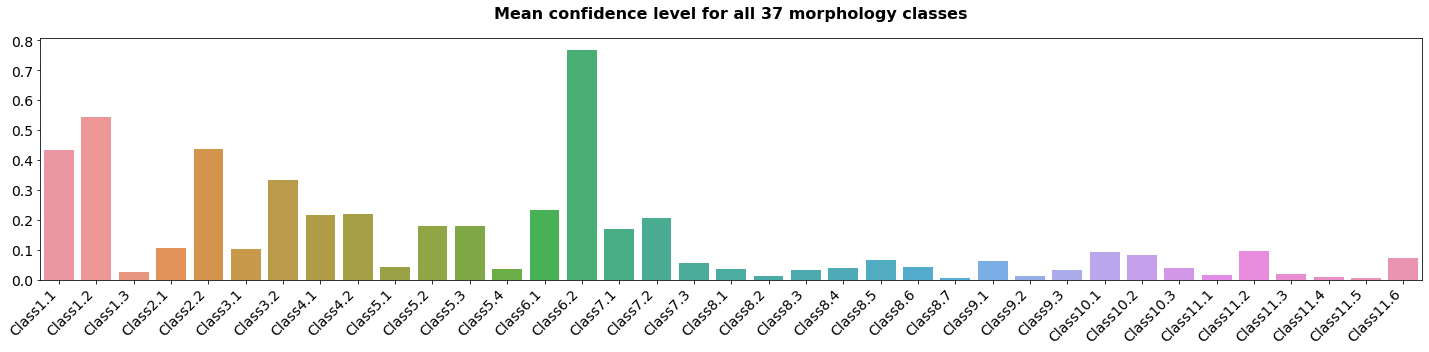

In [6]:
title = 'Mean confidence level for all 37 morphology classes'
plt.figure(figsize=(20, 5))
plt.title(title)
sns.barplot(x= labels.drop('GalaxyID', axis=1, inplace=False).mean().index, 
            y = labels.drop('GalaxyID', axis=1, inplace=False).mean().values)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14, rotation=45, ha='right')
plt.show()

The first thing I looked at was the instances of all classes where the confidence level was above 0.5. This is interesting to me as it will show the classes which are common and which are sparse in the dataset, and my main questions regarding this was whether I needed to apply weights to the loss function. If the classes were all evenly distributed, I could use an out of the box loss function. If not, I would need to write one that applies weights to prevent the neural network from over-prioritizing classes where there isn’t enough data to effectively learn.

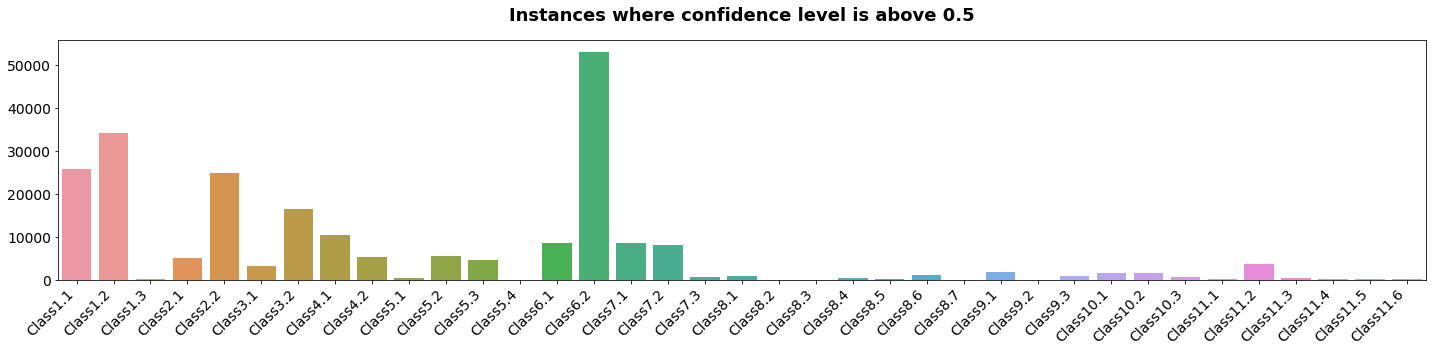

In [7]:
title = 'Instances where confidence level is above 0.5'
plt.figure(figsize=(20, 5))
plt.title(title, fontsize=18)
sns.barplot(x= labels.columns[1:] ,
            y = np.where(labels.drop('GalaxyID', axis=1, inplace=False).to_numpy() >= 0.5, 1, 0).sum(axis=0))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14, rotation=45, ha='right')
plt.show()

As you can see, the classes

- 6.2 (No odd feature)
- 1.2 (Featured or disc)
- 2.2 (Not edge on)
- 1.1 (Smooth)

are dominating the dataset, which makes sense, as most galaxies in the night sky would share atleast one or more features from this list.
We can also see that stars and artifacts (Class 1.3) are extremely rare in this dataset with only 44 instances; pretty much 0%. This means that we won't have to build a model that filters out these anomalies.
Following that I wanted to find out how strongly the participants agreed with each other. As we don’t really have a single source of truth, we’re not really modeling which galaxies have which features but we are actually measuring how confident the human scorers is that a galaxy has a certain attribute.
To understand this better, I plotted correlation matrices for the answers to each question as heatmaps.

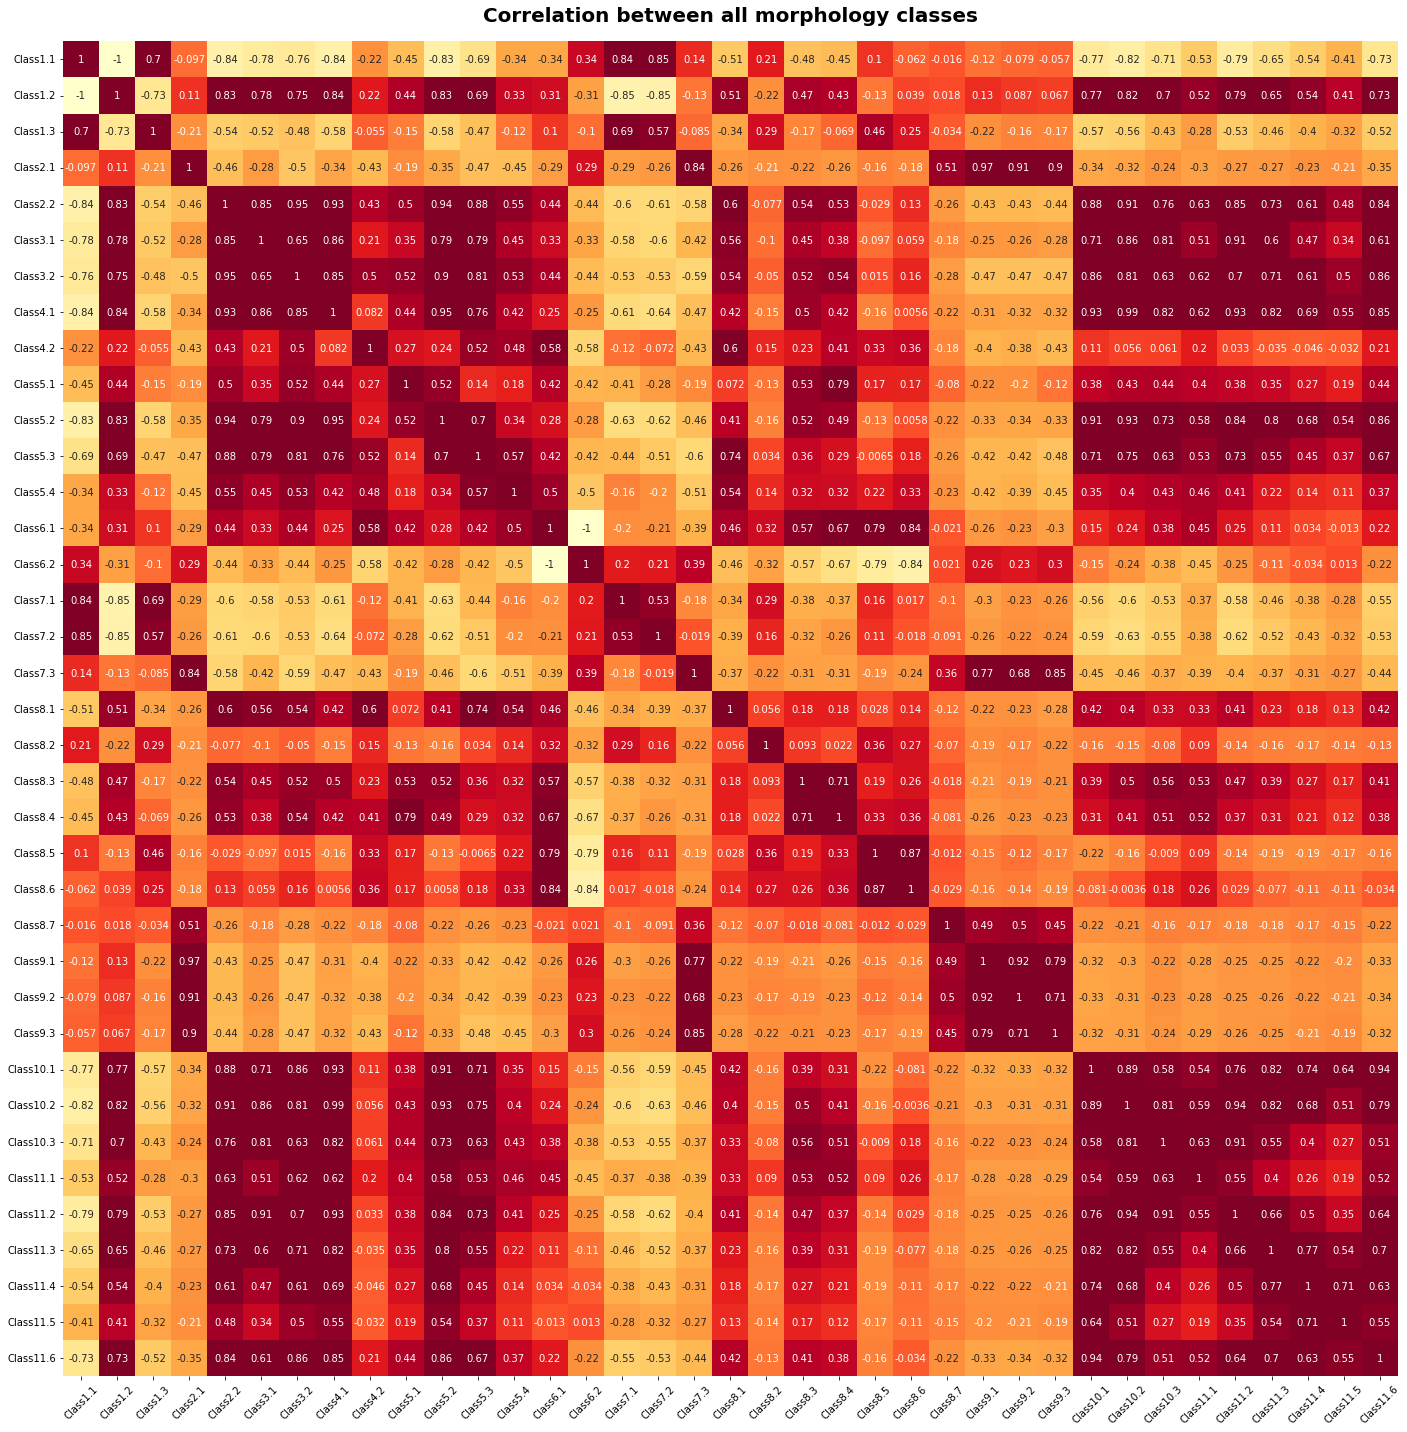

In [14]:
def heatmap(df, title):
    plt.figure(title, figsize=[20,20])
    plt.title(title, fontsize=20)
    df_corr = df.corr()
    sns.heatmap(df_corr, vmax=0.6, square=True, annot=True, cmap='YlOrRd', cbar=False)
    plt.yticks(rotation = 0)
    plt.xticks(rotation = 45)
    plt.show()

heatmap(labels.corr(), 'Correlation between all morphology classes')

This heatmap gives an overview of the correlations between all answers to every question.
We can observe that the relatively rare Class1.3 (stars or other non-galaxies) is correlated with the path through Class1.1 to ambiguous shapes and odd attribtes. Labelers may have confused galaxies with odd appearances and stars. Things like this are a reminder that hand-labeled data does not represent the absolute truth, but rather an approximation.

We can also see from the negative correlation between Class6.1 and Class6.2 that disagreement over whether an images had an odd feature was rare. Although there is high correlation between Class8.3/4/6 , which means that there was some confusion between disturbed, irregular, and merged galaxies.

Zooming into the individual questions shows us how well humans can discern between different attributes.

### Correlation heatmaps for each question

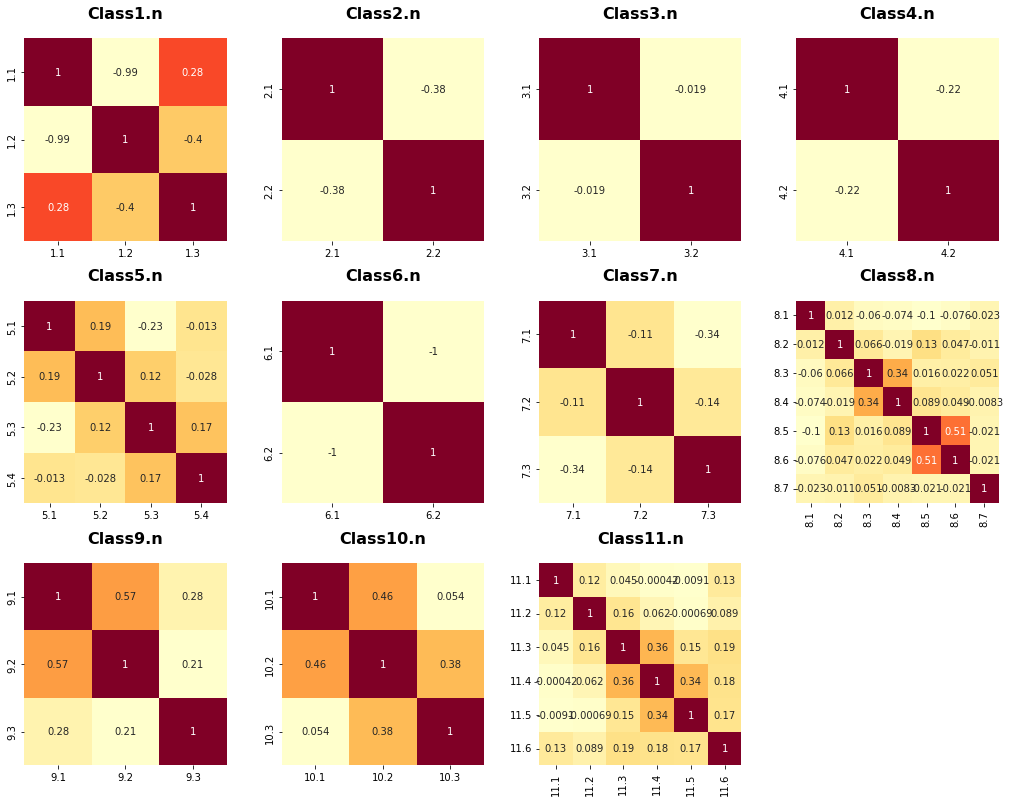

In [13]:
display(Markdown("### Correlation matrices for each of the 11 questions"))
size = 15
fig = plt.figure("Individual classes heatmaps", figsize=[size,size*3/4])
for i, group in enumerate(groups):
    fig.add_subplot(3, 4, i+1)
    plt.title('Class' + str(i+1) + '.n') 
    sns.heatmap(labels[group].corr(), square=True, annot=True,  cmap='YlOrRd', cbar=False)
    plt.xticks([x + 0.5 for x in range(len(group))], labels=[s.replace('Class','') for s in group])
    plt.yticks([y + 0.5 for y in range(len(group))], labels=[s.replace('Class','') for s in group])
fig.tight_layout(pad=3.0)
plt.show()

Class6.n shows us the ideal case where it is very unlikely for people to disagree over the galaxies with odd features, while Class9.n reveals that there is regularly confusion over the shape of the bulges and even over whether or not a bulge is present.

## Benchmarking

Although at heart, this is a classification problem, the objective of modeling the confidence level of humans classifcation transforms it into a regression problem.
As mentioned before, I’m going to be using an element-wise root mean-squared-error (RMSE) scoring function. Unlike classification problems where things like precision, confusion matrices, recall, and F-scores are easy to understand, RMSE is a bit more abstract. You can’t really say what a "good" RMSE score is, rather you have to set a baseline benchmark for the minimum possible performance and improve from there.

Provived with the dataset is a “central pixel benchmark” which achieved a RMSE of 0.16194. This is found by predicting the classes simply based on the average scores for images with the same central pixel. Looking at the Galaxy Zoo Challenge leaderboard most participants fall somewhere between 0.10 and 0.12 with the winner achieving a RMSE of just 0.07941.

But since this is a learning exercise, I decided to make my own little benchmark. I chose three strategies:

- Linear regression based on the **central pixels**
- Linear regression based on the **average pixels**
- **Average confidences** provided by the human classification

In [5]:
# Training/Testing/Validation splitting for Linear Regression
# -------------------

X, X_val, y, y_val = train_test_split(labels.GalaxyID, 
                                labels[labels.columns[1:]],  
                                test_size = 0.20, 
                                random_state = random.seed(42)  
                                )
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20,random_state = random.seed(42))

print("Training set: %d" % X_train.shape[0])
print("Testing set: %d" % X_test.shape[0])
print("Validation set: %d" % X_val.shape[0])

Training set: 39409
Testing set: 9853
Validation set: 12316


### Linear Regression based on the central pixels

In [23]:
ig = image_generator(X_train, batch_size=3000)
init = False
for step in ig: 
    if not init:
        centers_train = center_pixel(step)
        init = True; 
    else:
        centers_train = np.append(centers_train, center_pixel(step), axis=0)
save(centers_train, 'centers_train.p')

In [25]:
ig = image_generator(X_test, batch_size=3000)
init = False
for step in ig: 
    if not init:
        centers_test = center_pixel(step)
        init = True; 
    else:
        centers_test = np.append(centers_test, center_pixel(step), axis=0)

save(centers_test, 'centers_test.p')

In [34]:
print(centers_train.shape)
print(centers_test.shape)

(39409, 3)
(9853, 3)


In [35]:
lr = LinearRegression()
lr.fit(centers_train, y_train)
pred = lr.predict(centers_test)
print("Central Pixels RMSE is %.4f" % RMSE(pred, y_test))

Central Pixel RMSE is 0.1577


### Linear Regression based on the average pixels

In [38]:
ig = image_generator(X_train, batch_size=3000)
init = False
averages_train = 0
for step in ig: 
    if not init:
        averages_train = average_color(step)
        init = True; 
    else:
        averages_train = np.append(averages_train, average_color(step), axis=0)

save(averages_train, 'averages_train.p')

In [39]:
ig = image_generator(X_test, batch_size=3000)
init = False
averages_test = 0
for step in ig: 
    if not init:
        averages_test = average_color(step)
        init = True; 
    else:
        averages_test = np.append(averages_test, average_color(step), axis=0)

save(averages_test, 'averages_test.p')

In [40]:
print(averages_train.shape)
print(averages_test.shape)

(39409, 3)
(9853, 3)


In [41]:
lr = LinearRegression()
lr.fit(averages_train, y_train)
pred = lr.predict(averages_test)
print("Average Pixels RMSE is %.4f" % RMSE(pred, y_test))

Average Pixels RMSE is 0.1597


Both of these methods are better than the provided benchmark! But does this mean anything?

In [33]:
print("Average confidence RMSE is %.4f" % RMSE(np.broadcast_to(np.array(labels[labels.columns[1:]].mean()),(labels.shape[0], labels.shape[1]-1)), np.array(labels[labels.columns[1:]])))

Average confidence RMSE is 0.1639


Linear regression only just beats the prediction by the average confidences.
**Looks like we’ll have to use deep learning after all!**


## Preprocessing

Each of the provided images is of 424x424 pixels in size and comes in color (3 channels).
By examining the dataset, most images had large amount of black margins around the area of interest. Because of this, I decided to write a little region of interest algorithm which detects the most prominent part of the image and then crops each individual image to 150x150 pixels around its region of interest.
I also converted the images to grayscale, not only in order to reduce computational costs but mainly because the colored images gave me worst results while training.

In [ ]:
padding_size = 0.1

for image in labels.GalaxyID:

    im = cv2.imread(training_dir + image)
    im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY) #convert to grayscale
    ret, thresh = cv2.threshold(im, 10, 255, 0) 
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    ROI = (0,0,0,0) 
    ROI_area = 0
    for contour in contours: # cv.RETR_LIST exports contrours as a list. 
        x, y, width, height = cv2.boundingRect(contour)
        area = width * height 
        if area > ROI_area:
            ROI_area = area 
            ROI = (x,y,width,height) 
    
    x, y, width, height = ROI

    if width > height:
        pad = int(width * padding_size)
    else:
        pad = int(height * padding_size)
    
    if (y-pad >= 0 and 
        x-pad >= 0 and 
        y + max(width, height) + pad < im.shape[1] and 
        x + max(width, height) + pad < im.shape[0]):

        crop = im[y-pad:y+max(width,height)+pad,x-pad:x+max(width,height)+pad]
    else:
        crop = im
    
    image = image.replace('jpg','png')


    # 150x150 grayscale with margins
    cv2.imwrite(
        DIR_150 + image, 
        cv2.resize(crop, (150,150), interpolation=cv2.INTER_AREA)
    )

### Exploring the processed images

### The highest confidence example for each feature - 150x150 grayscale.

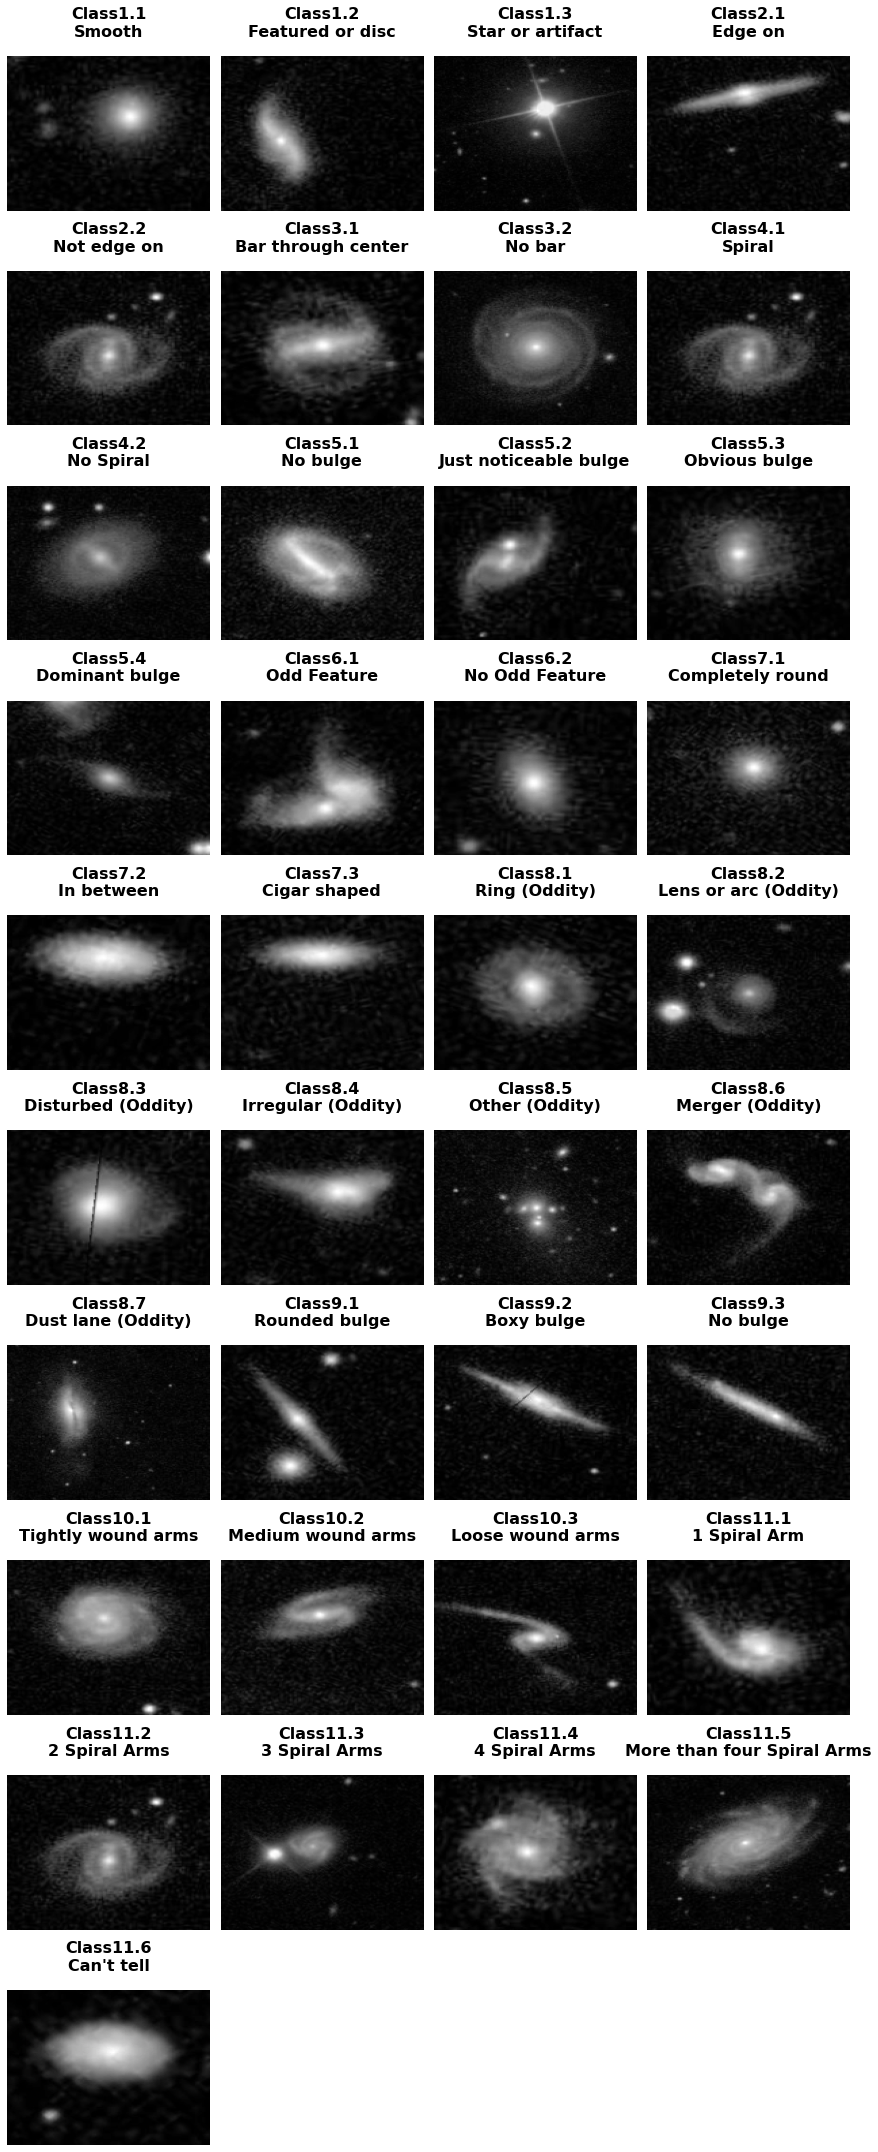

In [6]:
display(Markdown("### The highest confidence example for each feature - 150x150 grayscale."))
size = 12
fig = plt.figure('', figsize=[size,size*10/4])
plt.axis('off')
plt.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')
for i, feature in enumerate(labels.columns[1:]):
    fig.add_subplot(10, 4, i+1)
    plt.title(feature + "\n" + label_desc[i]) 
    plt.axis('off')
    plt.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')
    file = labels.iloc[labels[feature].idxmax()].GalaxyID
    img = plt.imread(DIR_150 + file.replace('jpg','png'), format='jpg')
    plt.imshow(img, aspect='auto', cmap='gray')
fig.tight_layout(pad=1.0)
plt.show()

I am still not 100% happy with my ROI detection as it sometimes crops off galaxies at the far edge and does not center some galaxies to the middle of the image.

## Building the Convolutional Neural Network

I chose to use a convolutional neural network (CNN) for this problem. CNNs are uniquely suited for image classification problems because they can explore local relationships between pixels, through a process we know as convolution, rather than looking at the whole picture all at once. Their ability to detect features in even large images makes them superior to standard feed forward and recurrent neural networks.

In [9]:
# Dataset preparation
# ---------------------

BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

def get_features(image_path, training=True):
    image = tf.io.decode_image(tf.io.read_file(image_path), dtype=tf.dtypes.float32)
    if training:
        label = tf.strings.split(image_path, os.path.sep)[3] # take the galaxy number from image path
        galaxyID = int(tf.strings.substr(label, 0, tf.strings.length(label)-4)) # remove .jpg extension
        galaxy_row = labels.loc[labels['GalaxyID'] == galaxyID]
        features = tf.cast(galaxy_row.iloc[0,1:].values, tf.float32)
        return image, features
    else:
        return image
    
def dataset_preprocessing(images_path, training=True, tpu=False):
    images_path_ds = tf.data.Dataset.from_tensor_slices(images_path)
    
    if training:
        dataset = images_path_ds.map(lambda x: tf.py_function(func=get_features, inp=[x], Tout=(tf.float32,tf.float32)),num_parallel_calls=AUTOTUNE)
    else:
        dataset = images_path_ds.map(lambda x: tf.py_function(func=get_features, inp=[x,False], Tout=tf.float32),num_parallel_calls=AUTOTUNE)
        
    dataset = dataset.shuffle(1024) if training else dataset # 2048
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE) # Add dataset prefetch() operations to reduce read latency while training the model
    return dataset

images_path = tf.io.gfile.glob('data/processed/150x150/*')
seed = 54
tf.random.set_seed(seed)
images_path = tf.random.shuffle(images_path)
samples_size = len(images_path)
print("Number of total samples: {}".format(samples_size))

# Split train validation sets for NN
splitIndex = int(np.floor(samples_size*0.8)) # 80/20 Training/Validation
images_path_train = images_path[:splitIndex]
images_path_val = images_path[splitIndex:]

print(images_path_train, images_path_val)
     
train_dataset = dataset_preprocessing(images_path_train)
print('Number of training batches: %d' % tf.data.experimental.cardinality(train_dataset))

val_dataset = dataset_preprocessing(images_path_val)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_dataset))

print("Dataset preprocessing done!")

Number of total samples: 61578
tf.Tensor(
[b'data/processed/150x150/778671.png' b'data/processed/150x150/825882.png'
 b'data/processed/150x150/229420.png' ...
 b'data/processed/150x150/135766.png' b'data/processed/150x150/614139.png'
 b'data/processed/150x150/522750.png'], shape=(49262,), dtype=string) tf.Tensor(
[b'data/processed/150x150/844863.png' b'data/processed/150x150/462861.png'
 b'data/processed/150x150/544091.png' ...
 b'data/processed/150x150/329423.png' b'data/processed/150x150/109215.png'
 b'data/processed/150x150/960149.png'], shape=(12316,), dtype=string)
Number of training batches: 770
Number of validation batches: 193
Dataset preprocessing done!


### Network architecture

The network architecture I came up with consists of 6 consecutive convolutional layers, each being activated by ReLU and followed by max-pooling and batch normalization. Towards the end of the network I introducted dropout layers, which in essence just randomly kick out neurons at each step during training, which helps prevent overfitting. After that we have a flatten layer to reduce dimensions for the then following fully-connected layers. I chose a set of 3 dense layers, with two of the three being activiated again with ReLU and the last one for the final prediction being a sigmoid activation function. This last dense layer brings us then to our desired shape of 1x37, for the 37 different morphology classes.

In [6]:
# Model architecture
# ---------------------

with tf.device('/GPU:0'):
    def create_model(input_shape):
        model = tf.keras.models.Sequential(name="galaxyclass", layers=[
            
            layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=input_shape),
            layers.experimental.preprocessing.RandomRotation(0.3),
            layers.experimental.preprocessing.RandomZoom(height_factor=0.1, width_factor=0.1, fill_mode="nearest"),
            layers.experimental.preprocessing.RandomContrast(0.05),       
                  
            layers.Conv2D(filters=32,kernel_size=(7, 7),activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(filters=32,kernel_size=(7, 7),activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(filters=64,kernel_size=(5, 5),activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(filters=64,kernel_size=(5, 5),activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(filters=128,kernel_size=(3, 3),activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D(pool_size=(1, 1)),
            layers.Conv2D(filters=256,kernel_size=(3, 3),activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D(pool_size=(1, 1)),
            layers.Dropout(0.05),
            layers.Flatten(),
            layers.Dense(512, activation='relu'),
            layers.Dropout(0.15),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.15),
            layers.Dense(37, activation='sigmoid')
        ])
        
        return model

    with strategy.scope(): 
        image_shape = (150,150,1) # (150,150,3) for color image
        model = create_model(image_shape)
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3) #0.001 
        loss_func = losses.MeanSquaredError() # Loss function (MSE)
        model.compile(loss=loss_func, optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError()])

    model.summary()

Model: "galaxyclass"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 150, 150, 1)       0         
                                                                 
 random_rotation (RandomRota  (None, 150, 150, 1)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 150, 150, 1)       0         
                                                                 
 random_contrast (RandomCont  (None, 150, 150, 1)      0         
 rast)                                                           
                                                                 
 conv2d (Conv2D)             (None, 144, 144, 32)      1600      
                                                                 
 batch_normalization (BatchN  (None, 144, 144, 32)     

After some consideration I settled on training my CNN with the Adam optimizer. You could think of Adam as an extension to classical stochastic gradient descent. While traditional SGD maintains a single learning rate for all weight updates and does not adapt during training, Adam and other variants of SGD can adjust the learning rate on the fly during training, which lets them achieve much faster convergence speeds than vanilla SGD. I still don't really know how to optimize their parameters and certainly can't appreciate how they work on a deeper mathematical level, but that is beyond the scope of this project. All you really have to know is that Adam is a little bit faster than stochastic gradient descent with comparable performance.

------- Training -------
Epoch 1/50


2022-02-07 21:45:28.157915: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8302
2022-02-07 21:45:29.577762: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-02-07 21:45:29.820708: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


770/770 [==============================] - 493s 623ms/step - loss: 0.0197 - root_mean_squared_error: 0.1405 - val_loss: 0.0225 - val_root_mean_squared_error: 0.1499
Epoch 2/50
770/770 [==============================] - 478s 611ms/step - loss: 0.0143 - root_mean_squared_error: 0.1197 - val_loss: 0.0147 - val_root_mean_squared_error: 0.1211
Epoch 3/50
770/770 [==============================] - 488s 624ms/step - loss: 0.0132 - root_mean_squared_error: 0.1147 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1100
Epoch 4/50
770/770 [==============================] - 473s 605ms/step - loss: 0.0125 - root_mean_squared_error: 0.1120 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1170
Epoch 5/50
770/770 [==============================] - 483s 618ms/step - loss: 0.0121 - root_mean_squared_error: 0.1098 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1075
Epoch 6/50
770/770 [==============================] - 470s 600ms/step - loss: 0.0118 - root_mean_squared_error: 0.1084 - val_loss: 

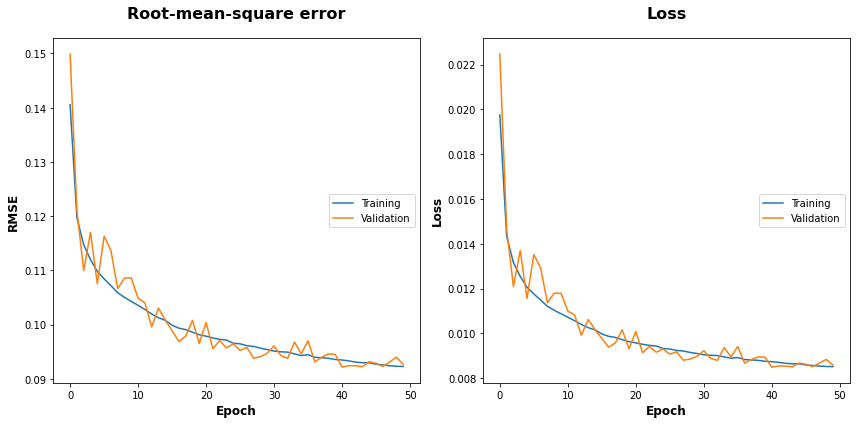

In [7]:
# Training
# ---------------------

with tf.device('/GPU:0'):
    epochs = 50
    verbose = True
    
    # Callbacks (https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/)
    
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=1e-5)
    def decay_schedule(epoch, lr):
        return lr * 0.8 if (epoch % 10 == 0) and (epoch != 0) else lr
    lr_scheduler = callbacks.LearningRateScheduler(decay_schedule)
    early_stop = callbacks.EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=7)
    checkpoint = callbacks.ModelCheckpoint('best_model', save_best_only=True, monitor='val_accuracy', mode='max')
    callbacksInUse = []

    print('------- Training -------') 
    start = time.time()
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, callbacks=callbacksInUse, use_multiprocessing=True, verbose=verbose)
    end = time.time()
    print("Total training took {:.2f} hours.".format((end - start)/3600))

    # Plot learning curves
    
    metrics = history.history
    fig, axes = plt.subplots(1, 2, figsize=(12,6))
    axes[0].plot(metrics['root_mean_squared_error'], label='Training')
    axes[0].plot(metrics['val_root_mean_squared_error'], label='Validation')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('RMSE')
    axes[0].legend(loc='center right')
    axes[0].set_title('Root-mean-square error')
    axes[1].plot(metrics['loss'], label='Training')
    axes[1].plot(metrics['val_loss'], label='Validation')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend(loc='center right')
    axes[1].set_title('Loss')
    plt.show()

As you can see in both the RMSE over epoch and loss over epoch, the model converges pretty well. Although I initially had trouble with the model overfitting after around 25 epochs. I solved this by increasing the depth of the network from the previous 3 consecutive convolutional layers to 6. I also saw major improvements after applying data augmentation, which helped the model quite a bit to increase its accuracy after epoch 25. Another key improvement came after finding the right combination of kernel and filter sizes. As it turn out CNNs with multiple consecutive convolutional layers learn best with increasing filter and decreasing kernel sizes. I was initially going to do a empirical approach to optimizing my model, meaning I would write a program that creates a bunch of models with different hyperparametes, trains them for a couple of epochs and then evaluates which combination yielded the best results. But due to time constraints I decided to just go with trial and error. Perhaps this is something I am going to revisit the next time I will build a neural network.

In [14]:
# Evaluation
# -------------------

results = model.evaluate(val_dataset, verbose=1)
print("Test RMSE: {:.4f}".format(results[1]))

193/193 [==============================] - 117s 554ms/step - loss: 0.0086 - root_mean_squared_error: 0.0926
Test RMSE: 0.0926


My final result is a respectable score of **0.0926**! I would have placed 28th in the original Galaxy Zoo competition. I am more than happy with my final score, as I had limited time to work on this project.

In [9]:
# Save model
# -------------------

modelPath = model_dir + model.name + "_test12.h5"
model.save(modelPath)
print("Model is saved: {}".format(modelPath))

Model is saved: data/models/galaxyclass_train420.h5


In [7]:
# Load model
# -------------------

model.load_weights('data/models/galaxyclass.h5')
print("Model is loaded succesfully!")

Model is loaded succesfully!
